https://www.youtube.com/watch?v=39vJRxIPSxw&feature=youtu.be&t=2757

https://github.com/dvysardana/RecommenderSystems_PyData_2016
          
Dataset Source: http://labrosa.ee.columbia.edu/millionsong/

In [1]:
import numpy as np
import pandas

#Class for Popularity based Recommender System model
class popularity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.popularity_recommendations = None
        
    #Create the popularity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

        #Get a count of user_ids for each unique song as recommendation score
        train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)
    
        #Sort the songs based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0,1])
    
        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
        #Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(10)

    #Use the popularity based recommender system model to
    #make recommendations
    def recommend(self, user_id):    
        user_recommendations = self.popularity_recommendations
        
        #Add user_id column for which the recommendations are being generated
        user_recommendations['user_id'] = user_id
    
        #Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols]
        
        return user_recommendations
    

#Class for Item similarity based Recommender System model
class item_similarity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.cooccurence_matrix = None
        self.songs_dict = None
        self.rev_songs_dict = None
        self.item_similarity_recommendations = None
        
    #Get unique items (songs) corresponding to a given user
    def get_user_items(self, user):
        user_data = self.train_data[self.train_data[self.user_id] == user]
        user_items = list(user_data[self.item_id].unique())
        
        return user_items
        
    #Get unique users for a given item (song)
    def get_item_users(self, item):
        item_data = self.train_data[self.train_data[self.item_id] == item]
        item_users = set(item_data[self.user_id].unique())
            
        return item_users
        
    #Get unique items (songs) in the training data
    def get_all_items_train_data(self):
        all_items = list(self.train_data[self.item_id].unique())
            
        return all_items
        
    #Construct cooccurence matrix
    def construct_cooccurence_matrix(self, user_songs, all_songs):
            
        ####################################
        #Get users for all songs in user_songs.
        ####################################
        user_songs_users = []        
        for i in range(0, len(user_songs)):
            user_songs_users.append(self.get_item_users(user_songs[i]))
            
        ###############################################
        #Initialize the item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = np.matrix(np.zeros(shape=(len(user_songs), len(all_songs))), float)
           
        #############################################################
        #Calculate similarity between user songs and all unique songs
        #in the training data
        #############################################################
        for i in range(0,len(all_songs)):
            #Calculate unique listeners (users) of song (item) i
            songs_i_data = self.train_data[self.train_data[self.item_id] == all_songs[i]]
            users_i = set(songs_i_data[self.user_id].unique())
            
            for j in range(0,len(user_songs)):       
                    
                #Get unique listeners (users) of song (item) j
                users_j = user_songs_users[j]
                    
                #Calculate intersection of listeners of songs i and j
                users_intersection = users_i.intersection(users_j)
                
                #Calculate cooccurence_matrix[i,j] as Jaccard Index
                if len(users_intersection) != 0:
                    #Calculate union of listeners of songs i and j
                    users_union = users_i.union(users_j)
                    
                    cooccurence_matrix[j,i] = float(len(users_intersection))/float(len(users_union))
                else:
                    cooccurence_matrix[j,i] = 0
                    
        
        return cooccurence_matrix

    
    #Use the cooccurence matrix to make top recommendations
    def generate_top_recommendations(self, user, cooccurence_matrix, all_songs, user_songs):
        print("Non zero values in cooccurence_matrix :%d" % np.count_nonzero(cooccurence_matrix))
        
        #Calculate a weighted average of the scores in cooccurence matrix for all user songs.
        user_sim_scores = cooccurence_matrix.sum(axis=0)/float(cooccurence_matrix.shape[0])
        user_sim_scores = np.array(user_sim_scores)[0].tolist()
 
        #Sort the indices of user_sim_scores based upon their value
        #Also maintain the corresponding score
        sort_index = sorted(((e,i) for i,e in enumerate(list(user_sim_scores))), reverse=True)
    
        #Create a dataframe from the following
        columns = ['user_id', 'song', 'score', 'rank']
        #index = np.arange(1) # array of numbers for the number of samples
        df = pandas.DataFrame(columns=columns)
         
        #Fill the dataframe with top 10 item based recommendations
        rank = 1 
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_songs[sort_index[i][1]] not in user_songs and rank <= 10:
                df.loc[len(df)]=[user,all_songs[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1
        
        #Handle the case where there are no recommendations
        if df.shape[0] == 0:
            print("The current user has no songs for training the item similarity based recommendation model.")
            return -1
        else:
            return df
 
    #Create the item similarity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

    #Use the item similarity based recommender system model to
    #make recommendations
    def recommend(self, user):
        
        ########################################
        #A. Get all unique songs for this user
        ########################################
        user_songs = self.get_user_items(user)    
            
        print("No. of unique songs for the user: %d" % len(user_songs))
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("No. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
                
        return df_recommendations
    
    #Get similar items to given items
    def get_similar_items(self, item_list):
        
        user_songs = item_list
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("No. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        user = ""
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
         
        return df_recommendations

In [2]:
#Class to calculate precision and recall

import random

class precision_recall_calculator():
    
    def __init__(self, test_data, train_data, pm, is_model):
        self.test_data = test_data
        self.train_data = train_data
        self.user_test_sample = None
        self.model1 = pm
        self.model2 = is_model
        
        self.ism_training_dict = dict()
        self.pm_training_dict = dict()
        self.test_dict = dict()
    
    #Method to return random percentage of values from a list
    def remove_percentage(self, list_a, percentage):
        k = int(len(list_a) * percentage)
        random.seed(0)
        indicies = random.sample(range(len(list_a)), k)
        new_list = [list_a[i] for i in indicies]
    
        return new_list
    
    #Create a test sample of users for use in calculating precision
    #and recall
    def create_user_test_sample(self, percentage):
        #Find users common between training and test set
        users_test_and_training = list(set(self.test_data['user_id'].unique()).intersection(set(self.train_data['user_id'].unique())))
        print("Length of user_test_and_training:%d" % len(users_test_and_training))

        #Take only random user_sample of users for evaluations
        self.users_test_sample = self.remove_percentage(users_test_and_training, percentage)

        print("Length of user sample:%d" % len(self.users_test_sample))
        
    #Method to generate recommendations for users in the user test sample
    def get_test_sample_recommendations(self):
        #For these test_sample users, get top 10 recommendations from training set
        #self.ism_training_dict = {}
        #self.pm_training_dict = {}

        #self.test_dict = {}

        for user_id in self.users_test_sample:
            #Get items for user_id from item similarity model
            print("Getting recommendations for user:%s" % user_id)
            user_sim_items = self.model2.recommend(user_id)
            self.ism_training_dict[user_id] = list(user_sim_items["song"])
    
            #Get items for user_id from popularity model
            user_sim_items = self.model1.recommend(user_id)
            self.pm_training_dict[user_id] = list(user_sim_items["song"])
    
            #Get items for user_id from test_data
            test_data_user = self.test_data[self.test_data['user_id'] == user_id]
            self.test_dict[user_id] = set(test_data_user['song'].unique() )
    
    #Method to calculate the precision and recall measures
    def calculate_precision_recall(self):
        #Create cutoff list for precision and recall calculation
        cutoff_list = list(range(1,11))


        #For each distinct cutoff:
        #    1. For each distinct user, calculate precision and recall.
        #    2. Calculate average precision and recall.

        ism_avg_precision_list = []
        ism_avg_recall_list = []
        pm_avg_precision_list = []
        pm_avg_recall_list = []


        num_users_sample = len(self.users_test_sample)
        for N in cutoff_list:
            ism_sum_precision = 0
            ism_sum_recall = 0
            pm_sum_precision = 0
            pm_sum_recall = 0
            ism_avg_precision = 0
            ism_avg_recall = 0
            pm_avg_precision = 0
            pm_avg_recall = 0

            for user_id in self.users_test_sample:
                ism_hitset = self.test_dict[user_id].intersection(set(self.ism_training_dict[user_id][0:N]))
                pm_hitset = self.test_dict[user_id].intersection(set(self.pm_training_dict[user_id][0:N]))
                testset = self.test_dict[user_id]
        
                pm_sum_precision += float(len(pm_hitset))/float(N)
                pm_sum_recall += float(len(pm_hitset))/float(len(testset))

                ism_sum_precision += float(len(ism_hitset))/float(len(testset))
                ism_sum_recall += float(len(ism_hitset))/float(N)
        
            pm_avg_precision = pm_sum_precision/float(num_users_sample)
            pm_avg_recall = pm_sum_recall/float(num_users_sample)
    
            ism_avg_precision = ism_sum_precision/float(num_users_sample)
            ism_avg_recall = ism_sum_recall/float(num_users_sample)

            ism_avg_precision_list.append(ism_avg_precision)
            ism_avg_recall_list.append(ism_avg_recall)
    
            pm_avg_precision_list.append(pm_avg_precision)
            pm_avg_recall_list.append(pm_avg_recall)
            
        return (pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list)
     

    #A wrapper method to calculate all the evaluation measures
    def calculate_measures(self, percentage):
        #Create a test sample of users
        self.create_user_test_sample(percentage)
        
        #Generate recommendations for the test sample users
        self.get_test_sample_recommendations()
        
        #Calculate precision and recall at different cutoff values
        #for popularity mode (pm) as well as item similarity model (ism)
        
        return self.calculate_precision_recall()
        #return (pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list)  

In [3]:
# Install packages

%matplotlib inline

import pandas
from sklearn.model_selection import train_test_split
import numpy as np
import time
import joblib
# import Recommenders as Recommenders
# import Evaluation as Evaluation

# Load data

In [4]:
#Read userid-songid-listen_count triplets
#This step might take time to download data from external sources
triplets_file = 'https://static.turi.com/datasets/millionsong/10000.txt'
songs_metadata_file = 'https://static.turi.com/datasets/millionsong/song_data.csv'

song_df_1 = pandas.read_table(triplets_file,header=None)
song_df_1.columns = ['user_id', 'song_id', 'listen_count']

#Read song  metadata
song_df_2 =  pandas.read_csv(songs_metadata_file)

#Merge the two dataframes above to create input dataframe for recommender systems
song_df = pandas.merge(song_df_1, song_df_2.drop_duplicates(['song_id']), on="song_id", how="left")

In [5]:
song_df_1.head()

,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [6]:
song_df_1.shape

(2000000, 3)

In [7]:
song_df_2.head()

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


In [8]:
song_df_2.shape

(1000000, 5)

# Explore data

In [9]:
song_df.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [10]:
song_df.shape

(2000000, 7)

In [11]:
song_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000000 entries, 0 to 1999999
Data columns (total 7 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user_id       object
 1   song_id       object
 2   listen_count  int64 
 3   title         object
 4   release       object
 5   artist_name   object
 6   year          int64 
dtypes: int64(2), object(5)
memory usage: 122.1+ MB


In [12]:
song_df.describe()

,listen_count,year
count,2.000000e+06,2.000000e+06
mean,3.045485e+00,1.628645e+03
std,6.579720e+00,7.787283e+02
min,1.000000e+00,0.000000e+00
25%,1.000000e+00,1.984000e+03
50%,1.000000e+00,2.002000e+03
75%,3.000000e+00,2.007000e+03
max,2.213000e+03,2.010000e+03


# Create a subset of dataset

In [13]:
song_df = song_df.iloc[:10000]

#Merge song title and artist_name columns to make a merged column
song_df['song'] = song_df['title'].map(str) + " - " + song_df['artist_name']

In [14]:
song_df.tail()

,user_id,song_id,listen_count,title,release,artist_name,year,song
9995,15cc706a7f24975ca831aaaf297bf0392746b3fe,SOFSETB12A8C134038,2,Show Me How To Live,Audioslave,Audioslave,2002,Show Me How To Live - Audioslave
9996,15cc706a7f24975ca831aaaf297bf0392746b3fe,SOHIROU12AB01852AF,5,Billy Liar,Billy Liar (CD-Single),The Decemberists,2003,Billy Liar - The Decemberists
9997,15cc706a7f24975ca831aaaf297bf0392746b3fe,SOOAVGC12AB01821EC,5,The Bachelor and the Bride,Her Majesty The Decemberists,The Decemberists,2003,The Bachelor and the Bride - The Decemberists
9998,15cc706a7f24975ca831aaaf297bf0392746b3fe,SOPKEIV12AB018220D,5,Red Right Ankle,Her Majesty The Decemberists,The Decemberists,2003,Red Right Ankle - The Decemberists
9999,15cc706a7f24975ca831aaaf297bf0392746b3fe,SOQSUMQ12AB01821F7,5,Song for Myla Goldberg,Her Majesty The Decemberists,The Decemberists,2003,Song for Myla Goldberg - The Decemberists


# Showing the most popular songs in the dataset

In [15]:
len(song_df['song'].unique())

5151

In [16]:
len(song_df['user_id'].unique())

365

In [17]:
# Count the number of 'listen_count' --> No. of user(s) listening the song 
song_grouped = song_df.groupby(['song']).agg({'listen_count': 'count'}).reset_index()
grouped_sum = song_grouped['listen_count'].sum()
song_grouped['percentage']  = song_grouped['listen_count'].div(grouped_sum)*100
song_grouped.sort_values(['listen_count', 'song'], ascending = [0,1]).head()

,song,listen_count,percentage
3660,Sehr kosmisch - Harmonia,45,0.45
4678,Undo - Björk,32,0.32
5105,You're The One - Dwight Yoakam,32,0.32
1071,Dog Days Are Over (Radio Edit) - Florence + Th...,28,0.28
3655,Secrets - OneRepublic,28,0.28


In [18]:
# Calculate total number of listenings
song_df.groupby('song')['listen_count'].sum().sort_values(ascending=False).head()

song
You're The One - Dwight Yoakam                                          519
Waiting For A Dream - Rufus Wainwright                                  247
Undo - Björk                                                            233
Revelry - Kings Of Leon                                                 149
Catch You Baby (Steve Pitron & Max Sanna Radio Edit) - Lonnie Gordon    146
Name: listen_count, dtype: int64

In [19]:
# Calculate total number of listenings
song_grouped = song_df.groupby(['song']).agg({'listen_count': 'sum'}).reset_index()
grouped_sum = song_grouped['listen_count'].sum()
song_grouped['percentage']  = song_grouped['listen_count'].div(grouped_sum)*100
song_grouped.sort_values(['listen_count', 'song'], ascending = [0,1]).head()

,song,listen_count,percentage
5105,You're The One - Dwight Yoakam,519,1.735148
4760,Waiting For A Dream - Rufus Wainwright,247,0.825783
4678,Undo - Björk,233,0.778978
3476,Revelry - Kings Of Leon,149,0.498144
726,Catch You Baby (Steve Pitron & Max Sanna Radio...,146,0.488115


In [20]:
len(song_df[song_df.song == 'Sehr kosmisch - Harmonia'])

45

In [21]:
len(song_df[song_df.song == 'Sehr kosmisch - Harmonia'].groupby('song')['user_id'].value_counts())

45

In [22]:
song_df[song_df.song == 'Sehr kosmisch - Harmonia'].groupby('song')['listen_count'].sum()

song
Sehr kosmisch - Harmonia    140
Name: listen_count, dtype: int64

In [23]:
song_df[song_df.song == 'Sehr kosmisch - Harmonia'].groupby('song')['listen_count'].value_counts(
    normalize=True,sort=True, ascending=False)

song                      listen_count
Sehr kosmisch - Harmonia  1               0.333333
                          2               0.311111
                          3               0.088889
                          5               0.088889
                          6               0.044444
                          7               0.044444
                          8               0.044444
                          4               0.022222
                          19              0.022222
Name: listen_count, dtype: float64

In [24]:
song_df[song_df.song == 'Sehr kosmisch - Harmonia'].groupby('song')['listen_count'].value_counts().unstack().fillna(0)

listen_count,1,2,3,4,5,6,7,8,19
song,,,,,,,,,
Sehr kosmisch - Harmonia,15,14,4,1,4,2,2,2,1


# Count number of unique users in the dataset

In [25]:
users = song_df['user_id'].unique()

In [26]:
len(users)

365

# Quiz 1. Count the number of unique songs in the dataset

In [27]:
songs = song_df['song'].unique()
len(songs)

5151

# Create a song recommender

In [28]:
train_data, test_data = train_test_split(song_df, test_size = 0.20, random_state=0)

In [29]:
train_data.head(5)

,user_id,song_id,listen_count,title,release,artist_name,year,song
7389,94d5bdc37683950e90c56c9b32721edb5d347600,SOXNZOW12AB017F756,2,Half Of My Heart,Battle Studies,John Mayer,0,Half Of My Heart - John Mayer
9275,1012ecfd277b96487ed8357d02fa8326b13696a5,SOXHYVQ12AB0187949,1,The Beautiful People,Antichrist Superstar (Ecopac Explicit),Marilyn Manson,0,The Beautiful People - Marilyn Manson
2995,15415fa2745b344bce958967c346f2a89f792f63,SOOSZAZ12A6D4FADF8,1,Sanctify Yourself,Glittering Prize 81/92,Simple Minds,1985,Sanctify Yourself - Simple Minds
5316,ffadf9297a99945c0513cd87939d91d8b602936b,SOWDJEJ12A8C1339FE,4,Heart Cooks Brain,Everything Is Nice: The Matador Records 10th A...,Modest Mouse,1997,Heart Cooks Brain - Modest Mouse
356,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAMPRJ12A8AE45F38,20,Rorol,Identification Parade,Octopus Project,2002,Rorol - Octopus Project


In [30]:
train_data.shape

(8000, 8)

In [31]:
test_data.shape

(2000, 8)

In [32]:
# Create an instance of popularity based recommender class
pm = popularity_recommender_py()
pm.create(train_data, 'user_id', 'song')

In [33]:
# Use the popularity model to make some predictions
user_id = users[5]
pm.recommend(user_id)

,user_id,song,score,Rank
3194,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Sehr kosmisch - Harmonia,37,1.0
4083,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Undo - Björk,27,2.0
931,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Dog Days Are Over (Radio Edit) - Florence + Th...,24,3.0
4443,4bd88bfb25263a75bbdd467e74018f4ae570e5df,You're The One - Dwight Yoakam,24,4.0
3034,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Revelry - Kings Of Leon,21,5.0
3189,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Secrets - OneRepublic,21,6.0
4112,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Use Somebody - Kings Of Leon,21,7.0
1207,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Fireflies - Charttraxx Karaoke,20,8.0
1577,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Hey_ Soul Sister - Train,19,9.0
1626,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Horn Concerto No. 4 in E flat K495: II. Romanc...,19,10.0


# Quiz 2: Use the popularity based model to make predictions for the following user id (Note the difference in recommendations from the first user id).

In [34]:
###Fill in the code here
user_id = users[7]
pm.recommend(user_id)

,user_id,song,score,Rank
3194,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Sehr kosmisch - Harmonia,37,1.0
4083,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Undo - Björk,27,2.0
931,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Dog Days Are Over (Radio Edit) - Florence + Th...,24,3.0
4443,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,You're The One - Dwight Yoakam,24,4.0
3034,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Revelry - Kings Of Leon,21,5.0
3189,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Secrets - OneRepublic,21,6.0
4112,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Use Somebody - Kings Of Leon,21,7.0
1207,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Fireflies - Charttraxx Karaoke,20,8.0
1577,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Hey_ Soul Sister - Train,19,9.0
1626,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Horn Concerto No. 4 in E flat K495: II. Romanc...,19,10.0


No matter what the user id is it is giving the same recommendations

# Build a song recommender with personalization
We now create an item similarity based collaborative filtering model that allows us to make personalized recommendations to each user.

# Class for an item similarity based personalized recommender system

In [35]:
# item similarity recommender
# # Create an instance of item similarity based recommender class
is_model = item_similarity_recommender_py()
is_model.create(train_data, 'user_id', 'song')

# Use the personalized model to make some song recommendations

In [38]:
user_id = users[5]

In [42]:
user5_data = train_data[train_data.user_id == user_id]
user5_data

,user_id,song_id,listen_count,title,release,artist_name,year,song
83,4bd88bfb25263a75bbdd467e74018f4ae570e5df,SOVEUVC12A6310EAF1,5,Just Lose It,Curtain Call,Eminem,2004,Just Lose It - Eminem
85,4bd88bfb25263a75bbdd467e74018f4ae570e5df,SOWGXOP12A6701E93A,8,Without Me,Without Me,Eminem,2002,Without Me - Eminem
84,4bd88bfb25263a75bbdd467e74018f4ae570e5df,SOWEHOM12A6BD4E09E,1,16 Candles,16 Candles,The Crests,1988,16 Candles - The Crests
87,4bd88bfb25263a75bbdd467e74018f4ae570e5df,SOXGQEM12AB0181D35,12,Speechless,The Fame Monster,Lady GaGa,2009,Speechless - Lady GaGa
86,4bd88bfb25263a75bbdd467e74018f4ae570e5df,SOWPAXV12A67ADA046,18,Push It,Ultimate Girl Groups,Salt-N-Pepa,1988,Push It - Salt-N-Pepa
76,4bd88bfb25263a75bbdd467e74018f4ae570e5df,SOEPZQS12A8C1436C7,13,Ghosts 'n' Stuff (Original Instrumental Mix),Ghosts 'n' Stuff,Deadmau5,2009,Ghosts 'n' Stuff (Original Instrumental Mix) -...
82,4bd88bfb25263a75bbdd467e74018f4ae570e5df,SOUSQCN12A8C133302,3,Say My Name,The Writing's On The Wall,Destiny's Child,1998,Say My Name - Destiny's Child
77,4bd88bfb25263a75bbdd467e74018f4ae570e5df,SOGDDKR12A6701E8FA,6,My Dad's Gone Crazy,The Eminem Show,Eminem / Hailie Jade,2006,My Dad's Gone Crazy - Eminem / Hailie Jade
80,4bd88bfb25263a75bbdd467e74018f4ae570e5df,SOKOXWU12AF72AD1BC,4,The Real Slim Shady,Curtain Call,Eminem,2000,The Real Slim Shady - Eminem
75,4bd88bfb25263a75bbdd467e74018f4ae570e5df,SODGVGW12AC9075A8D,6,Somebody To Love,My Worlds,Justin Bieber,2010,Somebody To Love - Justin Bieber


In [45]:
len(user5_data)

13

In [136]:
#Print the songs for the user in training data
user_id = users[5]
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

------------------------------------------------------------------------------------
Training data songs for the user userid: 4bd88bfb25263a75bbdd467e74018f4ae570e5df:
------------------------------------------------------------------------------------
Just Lose It - Eminem
Without Me - Eminem
16 Candles - The Crests
Speechless - Lady GaGa
Push It - Salt-N-Pepa
Ghosts 'n' Stuff (Original Instrumental Mix) - Deadmau5
Say My Name - Destiny's Child
My Dad's Gone Crazy - Eminem / Hailie Jade
The Real Slim Shady - Eminem
Somebody To Love - Justin Bieber
Forgive Me - Leona Lewis
Missing You - John Waite
Ya Nada Queda - Kudai
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 13
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :2097


,user_id,song,score,rank
0,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Superman - Eminem / Dina Rae,0.088692,1
1,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Mockingbird - Eminem,0.067663,2
2,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm Back - Eminem,0.065385,3
3,4bd88bfb25263a75bbdd467e74018f4ae570e5df,U Smile - Justin Bieber,0.064525,4
4,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Here Without You - 3 Doors Down,0.062293,5
5,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Hellbound - J-Black & Masta Ace,0.055769,6
6,4bd88bfb25263a75bbdd467e74018f4ae570e5df,The Seed (2.0) - The Roots / Cody Chestnutt,0.052564,7
7,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm The One Who Understands (Edit Version) - War,0.052564,8
8,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Falling - Iration,0.052564,9
9,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Armed And Ready (2009 Digital Remaster) - The ...,0.052564,10


# Quiz 3. Use the personalized model to make recommendations for the following user id. (Note the difference in recommendations from the first user id.)¶

In [46]:
user_id = users[7]

In [47]:
user7_data = train_data[train_data.user_id == user_id]
user7_data

,user_id,song_id,listen_count,title,release,artist_name,year,song
113,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,SOAUBGU12A6701C57A,2,Swallowed In The Sea,X & Y,Coldplay,2005,Swallowed In The Sea - Coldplay
117,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,SOICNON12A8C140437,4,Life In Technicolor ii,Viva La Vida - Prospekt's March Edition,Coldplay,2008,Life In Technicolor ii - Coldplay
114,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,SOCLQES12A58A7BB1D,2,Life In Technicolor,Viva La Vida Or Death And All His Friends,Coldplay,2008,Life In Technicolor - Coldplay
118,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,SOKLRPJ12A8C13C3FE,2,The Scientist,The Scientist,Coldplay,2002,The Scientist - Coldplay
123,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,SOZBZFF12A6310F12D,1,Trouble,Trouble (B-Side),Coldplay,2000,Trouble - Coldplay
116,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,SOEWTBE12A58A7E7C2,2,Strawberry Swing,Viva La Vida - Prospekt's March Edition,Coldplay,2008,Strawberry Swing - Coldplay
120,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,SOOWPBJ12A8C137FB4,2,Lost!,Viva La Vida Or Death And All His Friends,Coldplay,2008,Lost! - Coldplay
115,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,SOCVTLJ12A6310F0FD,2,Clocks,A Rush Of Blood To The Head,Coldplay,2002,Clocks - Coldplay


In [48]:
len(user7_data)

8

In [137]:
user_id = users[7]
#Fill in the code here
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

------------------------------------------------------------------------------------
Training data songs for the user userid: 9d6f0ead607ac2a6c2460e4d14fb439a146b7dec:
------------------------------------------------------------------------------------
Swallowed In The Sea - Coldplay
Life In Technicolor ii - Coldplay
Life In Technicolor - Coldplay
The Scientist - Coldplay
Trouble - Coldplay
Strawberry Swing - Coldplay
Lost! - Coldplay
Clocks - Coldplay
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 8
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :3429


,user_id,song,score,rank
0,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,She Just Likes To Fight - Four Tet,0.281579,1
1,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Warning Sign - Coldplay,0.281579,2
2,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,We Never Change - Coldplay,0.281579,3
3,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Puppetmad - Puppetmastaz,0.281579,4
4,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,God Put A Smile Upon Your Face - Coldplay,0.281579,5
5,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Susie Q - Creedence Clearwater Revival,0.281579,6
6,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,The Joker - Fatboy Slim,0.281579,7
7,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Korg Rhythm Afro - Holy Fuck,0.281579,8
8,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,This Unfolds - Four Tet,0.281579,9
9,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,high fives - Four Tet,0.281579,10


# find similar songs to any song in the dataset

In [143]:
is_model.get_similar_items(['Fix You - Coldplay'])

no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :803


,user_id,song,score,rank
0,,Yellow - Coldplay,0.375000,1
1,,Creep (Explicit) - Radiohead,0.368421,2
2,,Clocks - Coldplay,0.285714,3
3,,Billionaire [feat. Bruno Mars] (Explicit Albu...,0.285714,4
4,,Halo - Beyoncé,0.250000,5
5,,Day 'N' Nite - Kid Cudi Vs Crookers,0.250000,6
6,,Lucky (Album Version) - Jason Mraz & Colbie Ca...,0.250000,7
7,,The Funeral (Album Version) - Band Of Horses,0.235294,8
8,,Heartbreak Warfare - John Mayer,0.222222,9
9,,Nothin' On You [feat. Bruno Mars] (Album Versi...,0.217391,10


# Quiz 4. Use the personalized recommender model to get similar songs for the following song.

In [144]:
song = 'Yellow - Coldplay'
is_model.get_similar_items([song])

no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :969


,user_id,song,score,rank
0,,Fix You - Coldplay,0.375000,1
1,,Creep (Explicit) - Radiohead,0.291667,2
2,,Clocks - Coldplay,0.280000,3
3,,Seven Nation Army - The White Stripes,0.250000,4
4,,Paper Planes - M.I.A.,0.208333,5
5,,Halo - Beyoncé,0.200000,6
6,,The Funeral (Album Version) - Band Of Horses,0.181818,7
7,,In My Place - Coldplay,0.181818,8
8,,Kryptonite - 3 Doors Down,0.166667,9
9,,When You Were Young - The Killers,0.166667,10


# Quantitative comparison between the models
We now formally compare the popularity and the personalized models using precision-recall curves

# Use the above precision recall calculator class to calculate the evaluation measures

In [49]:
start = time.time()

#Define what percentage of users to use for precision recall calculation
user_sample = 0.005

#Instantiate the precision_recall_calculator class
pr = precision_recall_calculator(test_data, train_data, pm, is_model)

#Call method to calculate precision and recall values
(pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)

end = time.time()
print(end - start)

Length of user_test_and_training:319
Length of user sample:1
Getting recommendations for user:45544491ccfcdc0b0803c34f201a6287ed4e30f8
No. of unique songs for the user: 3
No. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :19
3.1716902256011963


In [55]:
start = time.time()

#Define what percentage of users to use for precision recall calculation
user_sample = 0.05

#Instantiate the precision_recall_calculator class
pr = precision_recall_calculator(test_data, train_data, pm, is_model)

#Call method to calculate precision and recall values
(pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)

end = time.time()
print(end - start)

Length of user_test_and_training:319
Length of user sample:15
Getting recommendations for user:45544491ccfcdc0b0803c34f201a6287ed4e30f8
No. of unique songs for the user: 3
No. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :19
Getting recommendations for user:94d5bdc37683950e90c56c9b32721edb5d347600
No. of unique songs for the user: 83
No. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :12592
Getting recommendations for user:672a1973a091e8ed8f4d46e3a740621f5fa4176c
No. of unique songs for the user: 11
No. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :3194
Getting recommendations for user:d5618c6813c7a067646edcf9c7243ccb95919460
No. of unique songs for the user: 21
No. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :1543
Getting recommendations for user:c01f9838d66929bd2494eb8e627054024a13d5c4
No. of unique songs for the user: 17
No. of unique songs in th

# Code to plot precision recall curve

In [56]:

import pylab as pl

#Method to generate precision and recall curve
def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label, m2_precision_list, m2_recall_list, m2_label):
    pl.clf()    
    pl.plot(m1_recall_list, m1_precision_list, label=m1_label)
    pl.plot(m2_recall_list, m2_precision_list, label=m2_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0, 0.20])
    pl.xlim([0.0, 0.20])
    pl.title('Precision-Recall curve')
    #pl.legend(loc="upper right")
    pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    pl.show()

Plotting precision recall curves.


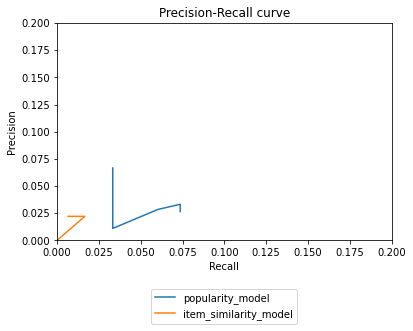

In [57]:
print("Plotting precision recall curves.")

plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")

# Generate Precision Recall curve using pickled results on a larger data subset

Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).
Plotting precision recall curves.


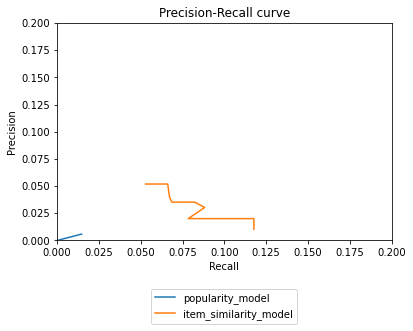

In [62]:
print("Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).")

#Read the persisted files 
pm_avg_precision_list = joblib.load('pm_avg_precision_list_3.pkl')
pm_avg_recall_list = joblib.load('pm_avg_recall_list_3.pkl')
ism_avg_precision_list = joblib.load('ism_avg_precision_list_3.pkl')
ism_avg_recall_list = joblib.load('ism_avg_recall_list_3.pkl')

print("Plotting precision recall curves.")
plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")


# Matrix Factorization based Recommender System
Using SVD matrix factorization based collaborative filtering recommender system -------------------------------------------------------------------------------- The following code implements a Singular Value Decomposition (SVD) based matrix factorization collaborative filtering recommender system. The user ratings matrix used is a small matrix as follows: Item0 Item1 Item2 Item3 User0 3 1 2 3 User1 4 3 4 3 User2 3 2 1 5 User3 1 6 5 2 User4 0 0 5 0 As we can see in the above matrix, all users except user 4 rate all items. The code calculates predicted recommendations for user 4.

Singular Value Decomposition (SVD) based matrix factorization collaborative filtering recommender system. The user ratings
matrix used is a smaill matrix as follows:

        Item0     Item1     Item2     Item3       
User0     3         1         2         3  
User1     4         3         4         3  
User2     3         2         1         5  
User3     1         6         5         2  
User4     0         0         5         0  

All users except 4 rate all items
The code calculates predicted recommendations for user 4

# Import the required libraries

In [66]:
#Code source written with help from: 
#http://antoinevastel.github.io/machine%20learning/python/2016/02/14/svd-recommender-system.html

import math as mt
import csv
from sparsesvd import sparsesvd #used for matrix factorization
import numpy as np
from scipy.sparse import csc_matrix #used for sparse matrix
from scipy.sparse.linalg import * #used for matrix multiplication

#Note: You may need to install the library sparsesvd. Documentation for 
#sparsesvd method can be found here:
#https://pypi.python.org/pypi/sparsesvd/

# Methods to compute SVD and recommendations

In [67]:
#constants defining the dimensions of our User Rating Matrix (URM)
MAX_PID = 4
MAX_UID = 5

#Compute SVD of the user ratings matrix
def computeSVD(urm, K):
    U, s, Vt = sparsesvd(urm, K)

    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i,i] = mt.sqrt(s[i])

    U = csc_matrix(np.transpose(U), dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)
    
    return U, S, Vt

#Compute estimated rating for the test user
def computeEstimatedRatings(urm, U, S, Vt, uTest, K, test):
    rightTerm = S*Vt 

    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        #we convert the vector to dense format in order to get the indices 
        #of the movies with the best estimated ratings 
        estimatedRatings[userTest, :] = prod.todense()
        recom = (-estimatedRatings[userTest, :]).argsort()[:250]
    return recom

# Use SVD to make predictions for a test user id, say 4

In [75]:
#Used in SVD calculation (number of latent factors)
K=2

#Initialize a sample user rating matrix
urm = np.array([[3, 1, 2, 3],[4, 3, 4, 3],[3, 2, 1, 5], [1, 6, 5, 2], [0, 0, 5, 0]])
urm = csc_matrix(urm, dtype=np.float32)

#Compute SVD of the input user ratings matrix
U, S, Vt = computeSVD(urm, K)

#Test user set as user_id 4 with ratings [0, 0, 5, 0]
uTest = [4]
print("User id for whom recommendations are needed: %d" % uTest[0])

#Get estimated rating for test user
print("Predictied ratings:")
uTest_recommended_items = computeEstimatedRatings(urm, U, S, Vt, uTest, K, True)
print(uTest_recommended_items)

User id for whom recommendations are needed: 4
Predictied ratings:
[2 1 0 3]


In [71]:
#Used in SVD calculation (number of latent factors, latent dimension)
K=2

#Initialize a sample user rating matrix
urm = np.array([[3, 1, 2, 3],[4, 3, 4, 3],[3, 2, 1, 5], [1, 6, 5, 2], [5, 0, 0, 0]])
urm = csc_matrix(urm, dtype=np.float32)

#Compute SVD of the input user ratings matrix
U, S, Vt = computeSVD(urm, K)

#Test user set as user_id 4 with ratings [0, 0, 5, 0]
uTest = [4]
print("User id for whom recommendations are needed: %d" % uTest[0])

#Get estimated rating for test user
print("Predictied ratings:")
uTest_recommended_items = computeEstimatedRatings(urm, U, S, Vt, uTest, K, True)
print(uTest_recommended_items)

User id for whom recommendations are needed: 4
Predictied ratings:
[0 3 2 1]


In [72]:
#Used in SVD calculation (number of latent factors)
K=2

#Initialize a sample user rating matrix
urm = np.array([[3, 1, 2, 3],[4, 3, 4, 3],[3, 2, 1, 5], [1, 6, 5, 2], [5, 0, 5, 0]])
urm = csc_matrix(urm, dtype=np.float32)

#Compute SVD of the input user ratings matrix
U, S, Vt = computeSVD(urm, K)

#Test user set as user_id 4 with ratings [0, 0, 5, 0]
uTest = [4]
print("User id for whom recommendations are needed: %d" % uTest[0])

#Get estimated rating for test user
print("Predictied ratings:")
uTest_recommended_items = computeEstimatedRatings(urm, U, S, Vt, uTest, K, True)
print(uTest_recommended_items)

User id for whom recommendations are needed: 4
Predictied ratings:
[0 2 3 1]


# Understanding Intuition behind SVD

SVD result gives three matrices as output: U, S and Vt (T in Vt means transpose). Matrix U represents user vectors and Matrix Vt represents item vectors. S represent the number of latent dimension. In simple terms, U represents users as 2 dimensional points in the latent vector space, and Vt represents items as 2 dimensional points in the same space. Next, we print the matrices U, S and Vt and try to interpret them. Think how the points for users and items will look like in a 2 dimensional axis. For example, the following code plots all user vectors from the matrix U in the 2 dimensional space. Similarly, we plot all the item vectors in the same plot from the matrix Vt.

Matrix Dimensions for U
(5, 2)


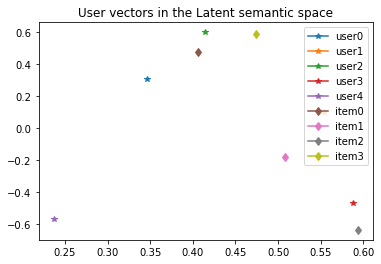

In [89]:
%matplotlib inline
from pylab import *

#Plot all the users
print("Matrix Dimensions for U")
print(U.shape)

for i in range(0, U.shape[0]):
    plot(U[i,0], U[i,1], marker = "*", label="user"+str(i))

for j in range(0, Vt.T.shape[0]):
    plot(Vt.T[j,0], Vt.T[j,1], marker = 'd', label="item"+str(j))    
    
legend(loc="upper right")
title('User vectors in the Latent semantic space')
# ylim([-0.7, 0.7])
# xlim([-0.2, 0.7])
show()

In [87]:
for i in range(0, U.shape[0]):
    print(U[i,0], U[i,1])

0.345828 0.3064413
0.5539063 0.09979897
0.41463652 0.59669423
0.5878473 -0.46632588
0.23686057 -0.5680053


In [84]:
for j in range(0, Vt.T.shape[0]):
    print(Vt.T[j,0], Vt.T[j,1]) 

0.40559745 0.47181165
0.5076207 -0.17833555
0.59389144 -0.63619757
0.47445226 0.5838174


## Resources

Book: Recommender Systems An Introduction by Dietmar Jannach
Book: Mining Massive Datasets by Jure Leskovec, Anand Rajaraman, Jeff Ullman www.mmds.org

Coursera course: Recommender Systems by University of Washington
Coursera course: Recommender Systems by University of Minnesota
